In [48]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot

/opt/conda/envs/attention_tsp/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


/opt/conda/envs/attention_tsp/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:402: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |    62/  310 batches | lr 0.005000 | 63.70 ms | loss 4.90329 | ppl   134.73
| epoch   1 |   124/  310 batches | lr 0.005000 | 63.19 ms | loss 0.10625 | ppl     1.11
| epoch   1 |   186/  310 batches | lr 0.005000 | 62.74 ms | loss 0.09824 | ppl     1.10
| epoch   1 |   248/  310 batches | lr 0.005000 | 63.50 ms | loss 0.09723 | ppl     1.10
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 21.07s | valid loss 0.04067 | valid ppl     1.04
-----------------------------------------------------------------------------------------
| epoch   2 |    62/  310 batches | lr 0.004513 | 65.34 ms | loss 0.02040 | ppl     1.02
| epoch   2 |   124/  310 batches | lr 0.004513 | 66.13 ms | loss 0.01499 | ppl     1.02
| epoch   2 |   186/  310 batches | lr 0.004513 | 64.83 ms | loss 0.01275 | ppl     1.01
| epoch   2 |   248/  310 batches | lr 0.004513 | 63.67 ms | loss 0.02135 | ppl     1.02
--------------------------------

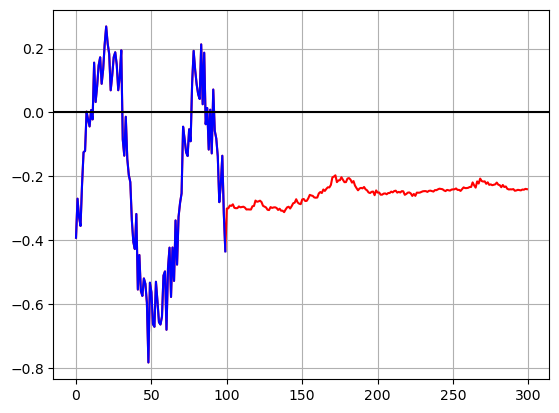

-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 22.38s | valid loss 0.04031 | valid ppl     1.04
-----------------------------------------------------------------------------------------
| epoch   6 |    62/  310 batches | lr 0.003675 | 69.85 ms | loss 0.01300 | ppl     1.01
| epoch   6 |   124/  310 batches | lr 0.003675 | 64.27 ms | loss 0.01142 | ppl     1.01
| epoch   6 |   186/  310 batches | lr 0.003675 | 63.23 ms | loss 0.01367 | ppl     1.01
| epoch   6 |   248/  310 batches | lr 0.003675 | 63.70 ms | loss 0.01273 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 21.55s | valid loss 0.04083 | valid ppl     1.04
-----------------------------------------------------------------------------------------
| epoch   7 |    62/  310 batches | lr 0.003492 | 64.27 ms | loss 0.01182 | ppl     1.01
| epoch   7 |   124/  310 batches | lr 0.00

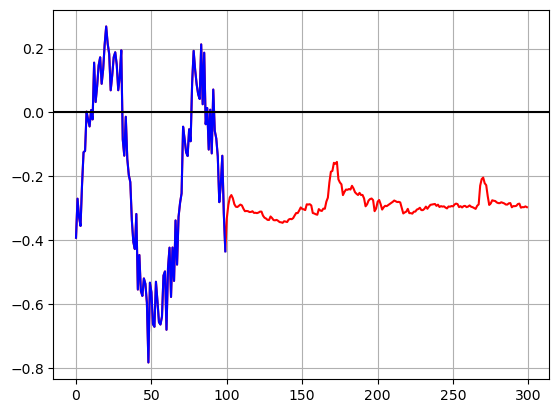

-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 22.34s | valid loss 0.03753 | valid ppl     1.04
-----------------------------------------------------------------------------------------


In [51]:
torch.manual_seed(0)
np.random.seed(0)

# S is the source sequence length
# T is the target sequence length
# N is the batch size
# E is the feature number

#src = torch.rand((10, 32, 512)) # (S,N,E) 
#tgt = torch.rand((20, 32, 512)) # (T,N,E)
#out = transformer_model(src, tgt)

input_window = 100 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
block_len = input_window + output_window # for one input-output pair
batch_size = 10
train_size = 0.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # div_term = torch.exp(
        #     torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        # )
        div_term = 1 / (10000 ** ((2 * np.arange(d_model)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[0::2])
        pe[:, 1::2] = torch.cos(position * div_term[1::2])

        pe = pe.unsqueeze(0).transpose(0, 1) # [5000, 1, d_model],so need seq-len <= 5000
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        # print(self.pe[:x.size(0), :].repeat(1,x.shape[1],1).shape ,'---',x.shape)
        # dimension 1 maybe inequal batchsize
        return x + self.pe[:x.size(0), :].repeat(1,x.shape[1],1)
          

class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.input_embedding  = nn.Linear(1,feature_size)
        self.src_mask = None

        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        # src with shape (input_window, batch_len, 1)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.input_embedding(src) # linear transformation before positional embedding
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
'''
In fact, assuming that the number of samples is N, 
the length of the input sequence is m, and the backward prediction is k steps, 
then length of a block [input : 1 , 2 ... m  -> output : k , k+1....m+k ] 
should be (m+k) :  block_len, so to ensure that each block is complete, 
the end element of the last block should be the end element of the entire sequence, 
so the actual number of blocks is [N - block_len + 1] 
'''
def create_inout_sequences(input_data, input_window ,output_window):
    inout_seq = []
    L = len(input_data)
    block_num =  L - block_len + 1
    # total of [N - block_len + 1] blocks
    # where block_len = input_window + output_window

    for i in range( block_num ):
        train_seq = input_data[i : i + input_window]
        train_label = input_data[i + output_window : i + input_window + output_window]
        inout_seq.append((train_seq ,train_label))

    return torch.FloatTensor(np.array(inout_seq))

def get_data():
    # construct a littel toy dataset
    time        = np.arange(0, 400, 0.1)    
    amplitude   = np.sin(time) + np.sin(time * 0.05) + \
                  np.sin(time * 0.12) * np.random.normal(-0.2, 0.2, len(time))

    from sklearn.preprocessing import MinMaxScaler
    
    #loading weather data from a file
    #from pandas import read_csv
    #series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
    
    # looks like normalizing input values curtial for the model
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #amplitude = scaler.fit_transform(series.to_numpy().reshape(-1, 1)).reshape(-1)
    amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)

    sampels = int(len(time) * train_size) # use a parameter to control training size
    train_data = amplitude[:sampels]
    test_data = amplitude[sampels:]

    # convert our train data into a pytorch train tensor
    #train_tensor = torch.FloatTensor(train_data).view(-1)

    train_sequence = create_inout_sequences( train_data,input_window ,output_window)
    '''
    train_sequence = train_sequence[:-output_window] # todo: fix hack? -> din't think this through, looks like the last n sequences are to short, so I just remove them. Hackety Hack..
    # looks like maybe solved
    '''
    #test_data = torch.FloatTensor(test_data).view(-1) 
    test_data = create_inout_sequences(test_data,input_window,output_window)
    '''
    test_data = test_data[:-output_window] # todo: fix hack?
    '''
    # shape with (block , sql_len , 2 )
    return train_sequence.to(device),test_data.to(device)


def get_batch(input_data, i , batch_size):

    # batch_len = min(batch_size, len(input_data) - 1 - i) #  # Now len-1 is not necessary
    batch_len = min(batch_size, len(input_data) - i)
    data = input_data[ i:i + batch_len ]
    input = torch.stack([item[0] for item in data]).view((input_window,batch_len,1))
    # ( seq_len, batch, 1 ) , 1 is feature size
    target = torch.stack([item[1] for item in data]).view((input_window,batch_len,1))
    return input, target

def train(train_data):
    model.train() # Turn on the train mode \o/
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data), batch_size)):  # Now len-1 is not necessary
        # data and target are the same shape with (input_window,batch_len,1)
        data, targets = get_batch(train_data, i , batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def plot_and_loss(eval_model, data_source,epoch):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        # for i in range(0, len(data_source) - 1):
        for i in range(len(data_source)):  # Now len-1 is not necessary
            data, target = get_batch(data_source, i , 1) # one-step forecast
            output = eval_model(data)            
            total_loss += criterion(output, target).item()
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy() -> no need to detach stuff.. 
    len(test_result)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth[:500],color="blue")
    pyplot.plot(test_result-truth,color="green")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('dump/transformer-epoch%d.png'%epoch)
    pyplot.close()
    return total_loss / i


# predict the next n steps based on the input data 
def predict_future(eval_model, data_source,steps):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    data, _ = get_batch(data_source , 0 , 1)
    with torch.no_grad():
        for i in range(0, steps):            
            output = eval_model(data[-input_window:])
            # (seq-len , batch-size , features-num)
            # input : [ m,m+1,...,m+n ] -> [m+1,...,m+n+1]
            data = torch.cat((data, output[-1:])) # [m,m+1,..., m+n+1]

    data = data.cpu().view(-1)
    
    # I used this plot to visualize if the model pics up any long therm structure within the data.
    pyplot.plot(data,color="red")       
    pyplot.plot(data[:input_window],color="blue")    
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('dump/transformer-future%d.png'%steps)
    pyplot.show()
    pyplot.close()
        

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        # for i in range(0, len(data_source) - 1, eval_batch_size): # Now len-1 is not necessary
        for i in range(0, len(data_source), eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            total_loss += len(data[0]) * criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

train_data, val_data = get_data()
model = TransAm().to(device)

criterion = nn.MSELoss()
lr = 0.005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

best_val_loss = float("inf")
epochs = 10 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    if ( epoch % 5 == 0 ):
        val_loss = plot_and_loss(model, val_data,epoch)
        predict_future(model, val_data,200)
    else:
        val_loss = evaluate(model, val_data)
   
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    #if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step() 

#src = torch.rand(input_window, batch_size, 1) # (source sequence length,batch size,feature number) 
#out = model(src)
#
#print(out)
#print(out.shape)

In [52]:
time        = np.arange(0, 400, 0.1)    
amplitude   = np.sin(time) + np.sin(time * 0.05) + \
                np.sin(time * 0.12) * np.random.normal(-0.2, 0.2, len(time))
